In [2]:
import glob, os, yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint as pp
import seaborn as sns
import trackml.dataset
import torch
from math_utils import cylindrical_to_cartesian
import math

In [3]:
# to get access to the pdg database 2024 version
import pdg
PdgApi = pdg.connect('sqlite:////home/nikin105/mlProject/data/pdg/pdgall-2024-v0.1.0.sqlite')

In [4]:
project_name = "mum5mup5-skewed"
image_dir = f"/home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/{project_name}/after_training"
os.makedirs(image_dir, exist_ok=True)
eventNum = 25193

In [5]:
feature_data = torch.load(f"/home/nikin105/mlProject/data/machineLearning/mum5mup5/training/skewed/training/test/{eventNum}", map_location=torch.device('cpu'))

for key in feature_data.keys:
	print(key,":")
	if key == "event_file":
		pp.pprint(feature_data[key])
	elif feature_data[key].ndim == 2:
		pp.pprint(feature_data[key][0:5,0:5])
	else:
		pp.pprint(feature_data[key][0:5])
	print()

pdgcode :
tensor([13, 13, 13, 13, 13])

edge_index :
tensor([[ 0,  0,  1,  1,  2],
        [ 1, 88, 92, 94,  3]])

x :
tensor([[ 0.2512, -0.4389,  0.0010],
        [ 0.2611, -0.4412,  0.0011],
        [ 0.2980, -0.4441,  0.0015],
        [ 0.3079, -0.4459,  0.0041],
        [ 0.2481,  0.5733,  0.0035]], grad_fn=<SliceBackward0>)

modulewise_true_edges :
tensor([[ 0,  1,  2,  3, 11],
        [ 1,  2,  3, 11, 18]])

charge :
tensor([1, 1, 1, 1, 1], dtype=torch.int32)

pid :
tensor([3., 3., 3., 3., 5.], dtype=torch.float64)

scores :
tensor([9.9998e-01, 3.9643e-05, 4.0899e-05, 9.9995e-01, 9.9998e-01])

event_file :
'/scratch/tmp/n_inde01/mlSamples/mum5mup5/merged/csv/event0000025193'

y_pid :
tensor([ True, False, False,  True,  True])

hid :
tensor([175, 176, 179, 180, 125], dtype=torch.int32)

pphi :
tensor([-1.2819, -1.2788, -1.2684, -1.2654,  1.9152])

peta :
tensor([-0.8524, -0.8523, -0.8526, -0.8528, -0.1913])

vertex :
tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.

In [6]:
def plotSTT(useGrayScale=False, alpha=1):
    
	# import the STT geometry data
	sttGeo = pd.read_csv('/home/nikin105/mlProject/data/detectorGeometries/tubePos.csv', usecols=["x","y","skewed"])

	posSkewedTubes = sttGeo.query('skewed == 1')
	negSkewedTubes = sttGeo.query('skewed == -1')
	straightTubes  = sttGeo.query('skewed == 0')

	# Close all previous plots
	plt.close('all')

	# Set the general style of the plot using seaborn
	sns.set_theme()
	sns.set_style("ticks")
	sns.set_context("talk")

	pipeColors = sns.color_palette("pastel")

	if useGrayScale:
		posSkewedColor = 'gray'
		negSkewedColor = 'darkgray'
		straightColor  = 'lightgray'
	else:
		posSkewedColor = pipeColors[3]
		negSkewedColor = pipeColors[0]
		straightColor  = pipeColors[2]

	# Create a figure and axis
	fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

	ax.scatter(posSkewedTubes['x'], posSkewedTubes['y'], ec=posSkewedColor, fc="none", s=20, alpha=alpha)
	ax.scatter(negSkewedTubes['x'], negSkewedTubes['y'], ec=negSkewedColor, fc="none", s=20, alpha=alpha)
	ax.scatter(straightTubes['x'] , straightTubes['y'] , ec=straightColor , fc="none", s=20, alpha=alpha)

	# plotting params
	ax.set_xlabel('x [cm]')
	ax.set_ylabel('y [cm]')
	ax.set_aspect('equal')

	sns.despine(fig=fig, ax=ax, offset=10, trim=True)

	fig.tight_layout()

	return fig, ax

In [7]:
particleNameDict = {
	"p"         : r"p",
	"pbar"      : r"\bar{p}",
	"pi+"       : r"\pi^+",
	"pi-"       : r"\pi^-",
	"e+"        : r"e^+",
	"e-"        : r"e^-",
	"Xibar+"    : r"\bar{\Xi}^+",
	"Xi-"       : r"\Xi^-",
	"Lambda0"   : r"\Lambda^0",
	"Lambdabar0": r"\bar{\Lambda}^0",
	"mu+"       : r"\mu^+",
	"mu-"       : r"\mu^-",
}

In [8]:
def makeTrackDict(trackIDs, trackParameter, trackDict):
	""" This function creates a dictionary with the trackID as the key and arrays with track parameters (coordinates, momenta, etc.)
	    corresponding to the trackID as the values

	Args:
		trackIDs (array): List of track IDs
		trackParameter (array): List of track parameters
		trackDict (dictionary): Dictionary with trackID as the key and arrays with track parameters as the values

	Returns:
		dictionary: Dictionary with trackID as the key and arrays with track parameters as the values
	"""
	point = 0
 	# Iterate over all track IDs
	for trackID in trackIDs:
		if trackID not in trackDict:
			trackDict[trackID]  = np.zeros(0)
		trackDict[trackID]  = np.append(trackDict[trackID], trackParameter[point])
		point += 1
	return trackDict

In [9]:
def getParticleTexName(pdgID):
	"""Get the latex formatted name of a particle from its PDG ID

	Args:
		pdgID (int, string): PDG ID

	Returns:
		string: Latex formatted name of the particle
	"""
	return particleNameDict[PdgApi.get_particle_by_mcid(str(pdgID)).name]

In [10]:
feature_data.x = feature_data.x.detach().numpy()

991
1982
0.9999516010284424
0.9999485015869141


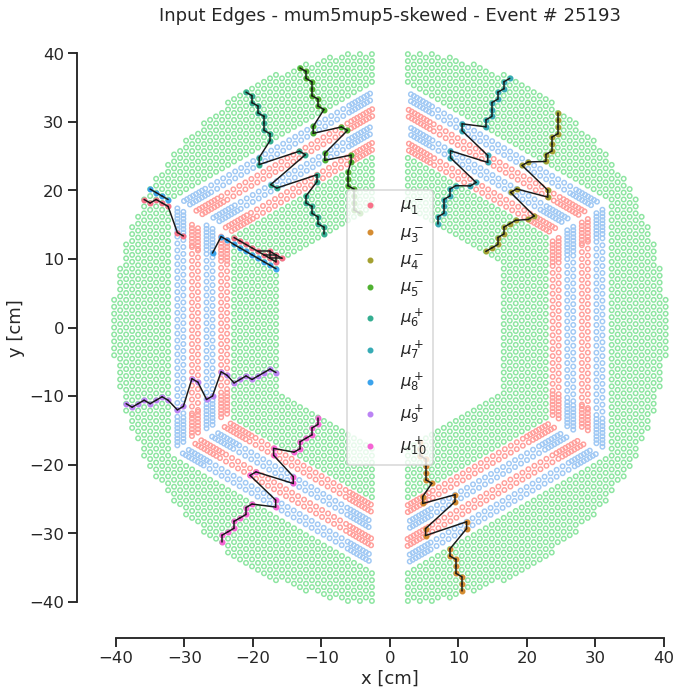

In [11]:
input_edges = feature_data.edge_index

print(len(input_edges[0]))
print(len(feature_data.scores))
print(feature_data.scores[3].item())
print(feature_data.scores[3+len(input_edges[0])].item())

fig, ax = plotSTT()

# feature data
x,y,_ = cylindrical_to_cartesian(r=feature_data.x[:, 0], phi=feature_data.x[:, 1], z=feature_data.x[:, 2])
    
# particle tracks
uniqueIds = np.unique(feature_data.pid)
numUniqueIds = len(uniqueIds)
particleColors = sns.color_palette("husl", numUniqueIds)

trackNum = 0
for pid in uniqueIds:
    idx = feature_data.pid == pid
    ax.scatter(x[idx], y[idx], label=f"${getParticleTexName(feature_data.pdgcode[idx][0].item())}_{{{pid:.0f}}}$", color=particleColors[trackNum], s=20)
    trackNum += 1
    
# # input edges
# for iedge in range(len(input_edges[0])):
#     ptx1 = x[input_edges[0][iedge]]
#     ptx2 = x[input_edges[1][iedge]]
#     pty1 = y[input_edges[0][iedge]]
#     pty2 = y[input_edges[1][iedge]]
#     ax.plot([ptx1, ptx2], [pty1, pty2], color='k', alpha=feature_data.scores[iedge].item(), lw=1.5)

for iedge in range(len(input_edges[0])):
    ptx1 = x[input_edges[1][iedge]]
    ptx2 = x[input_edges[0][iedge]]
    pty1 = y[input_edges[1][iedge]]
    pty2 = y[input_edges[0][iedge]]
    ax.plot([ptx1, ptx2], [pty1, pty2], color='k', alpha=feature_data.scores[iedge+len(input_edges[0])].item(), lw=1.5)

ax.set_title(f'Input Edges - {project_name} - Event # {eventNum}')
ax.legend(loc='center')

fig.savefig(f"{image_dir}/edge_score_{eventNum}.pdf", dpi=300)
fig.savefig(f"{image_dir}/edge_score_{eventNum}.png", dpi=300)

991
1982
0.9999516010284424
0.9999485015869141


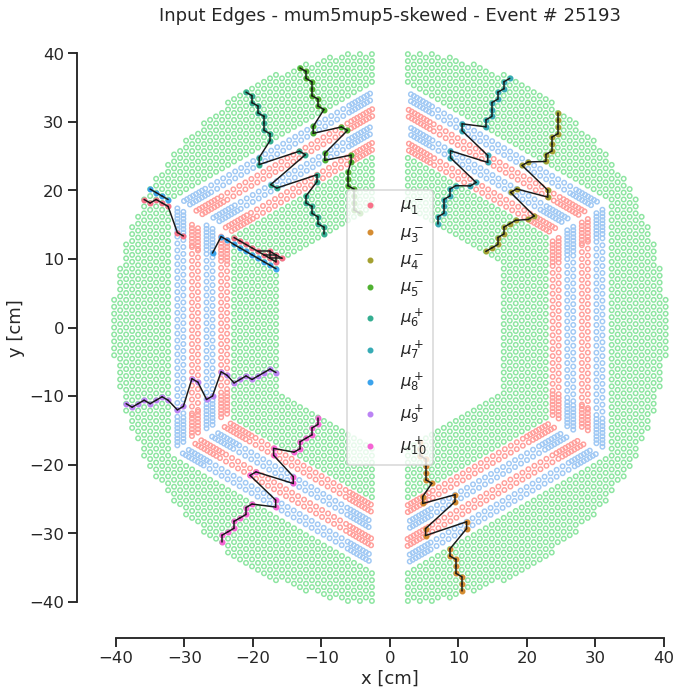

In [12]:
input_edges = feature_data.edge_index

print(len(input_edges[0]))
print(len(feature_data.scores))
print(feature_data.scores[3].item())
print(feature_data.scores[3+len(input_edges[0])].item())

fig, ax = plotSTT()

# feature data
x,y,_ = cylindrical_to_cartesian(r=feature_data.x[:, 0], phi=feature_data.x[:, 1], z=feature_data.x[:, 2])
    
# particle tracks
uniqueIds = np.unique(feature_data.pid)
numUniqueIds = len(uniqueIds)
particleColors = sns.color_palette("husl", numUniqueIds)

trackNum = 0
for pid in uniqueIds:
    idx = feature_data.pid == pid
    ax.scatter(x[idx], y[idx], label=f"${getParticleTexName(feature_data.pdgcode[idx][0].item())}_{{{pid:.0f}}}$", color=particleColors[trackNum], s=20)
    trackNum += 1
    
# # input edges
for iedge in range(len(input_edges[0])):
    ptx1 = x[input_edges[0][iedge]]
    ptx2 = x[input_edges[1][iedge]]
    pty1 = y[input_edges[0][iedge]]
    pty2 = y[input_edges[1][iedge]]
    ax.plot([ptx1, ptx2], [pty1, pty2], color='k', alpha=feature_data.scores[iedge].item(), lw=1.5)

# for iedge in range(len(input_edges[0])):
#     ptx1 = x[input_edges[1][iedge]]
#     ptx2 = x[input_edges[0][iedge]]
#     pty1 = y[input_edges[1][iedge]]
#     pty2 = y[input_edges[0][iedge]]
#     ax.plot([ptx1, ptx2], [pty1, pty2], color='k', alpha=feature_data.scores[iedge+len(input_edges[0])].item(), lw=1.5)

ax.set_title(f'Input Edges - {project_name} - Event # {eventNum}')
ax.legend(loc='center')

fig.savefig(f"{image_dir}/input_edges_{eventNum}.pdf", dpi=300)
fig.savefig(f"{image_dir}/input_edges_{eventNum}.png", dpi=300)

991
0.9999516010284424
0.9999485015869141
/home/nikin105/sciebo/Doktor/ML-Project/Images/machineLearning/mum5mup5-skewed/after_training/edge_scores_hit30_25193.png


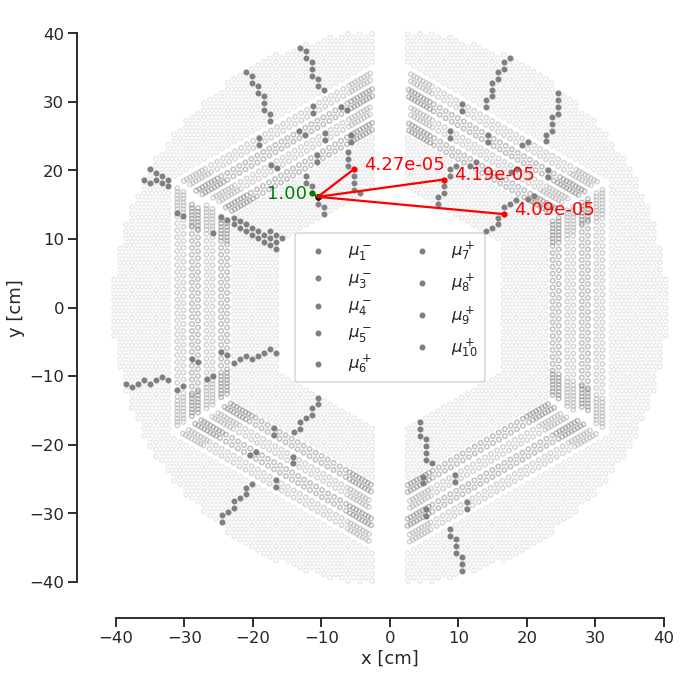

In [56]:
hitNum = 30

input_edges = feature_data.edge_index

print(len(input_edges[0]))
print(feature_data.scores[3].item())
print(feature_data.scores[3+len(input_edges[0])].item())

fig, ax = plotSTT(useGrayScale=True, alpha=0.5)

# feature data
x,y,_ = cylindrical_to_cartesian(r=feature_data.x[:, 0], phi=feature_data.x[:, 1], z=feature_data.x[:, 2])
    
# particle tracks
uniqueIds = np.unique(feature_data.pid)
numUniqueIds = len(uniqueIds)
particleColors = sns.color_palette("husl", numUniqueIds)

trackNum = 0
for pid in uniqueIds:
    idx = feature_data.pid == pid
    ax.scatter(x[idx], y[idx], label=f"${getParticleTexName(feature_data.pdgcode[idx][0].item())}_{{{pid:.0f}}}$", color="gray", s=20)
    trackNum += 1
    
# input edges
i=0

for iedge in range(len(input_edges[0])):
    if input_edges[0][iedge] != hitNum:
        continue
    if i==4:
        break
    if feature_data.scores[iedge].item() < 0.9:
        ptx1 = x[input_edges[0][iedge]]
        ptx2 = x[input_edges[1][iedge]]
        pty1 = y[input_edges[0][iedge]]
        pty2 = y[input_edges[1][iedge]]
        ax.scatter([ptx1, ptx2], [pty1, pty2], color='red', s=20)
        ax.plot([ptx1, ptx2], [pty1, pty2], color='red')

        midpointx = (ptx1 + ptx2) / 2
        midpointy = (pty1 + pty2) / 2

        ax.annotate(f'{feature_data.scores[iedge].item():.2e}', xy=(ptx2, pty2), color='red',xytext=(10,0),textcoords='offset points')
    else:
        ptx1 = x[input_edges[0][iedge]]
        ptx2 = x[input_edges[1][iedge]]
        pty1 = y[input_edges[0][iedge]]
        pty2 = y[input_edges[1][iedge]]
        ax.scatter([ptx1, ptx2], [pty1, pty2], color='green', s=20)
        ax.plot([ptx1, ptx2], [pty1, pty2], color='green')

        midpointx = (ptx1 + ptx2) / 2
        midpointy = (pty1 + pty2) / 2

        ax.annotate(f'{feature_data.scores[iedge].item():.2f}', xy=(ptx2, pty2), color='green',  xytext=(-45,-5),textcoords='offset points')
    i += 1

ax.scatter(x[hitNum], y[hitNum], s=20, color="black")

# for iedge in range(len(input_edges[0])):
#     if input_edges[0][iedge] != hitNum:
#         continue
#     ptx1 = x[input_edges[1][iedge]]
#     ptx2 = x[input_edges[0][iedge]]
#     pty1 = y[input_edges[1][iedge]]
#     pty2 = y[input_edges[0][iedge]]
#     ax.plot([ptx1, ptx2], [pty1, pty2], color='k', alpha=0.5, lw=1.5)

# ax.set_title(f'Input Edges - {project_name} - Event # {eventNum}')
ax.legend(loc='center', ncol=2)

print(f"{image_dir}/edge_scores_hit{hitNum}_{eventNum}.png")
fig.savefig(f"{image_dir}/edge_scores_hit{hitNum}_{eventNum}.pdf", dpi=300)
fig.savefig(f"{image_dir}/edge_scores_hit{hitNum}_{eventNum}.png", dpi=300)

203
0.999976634979248


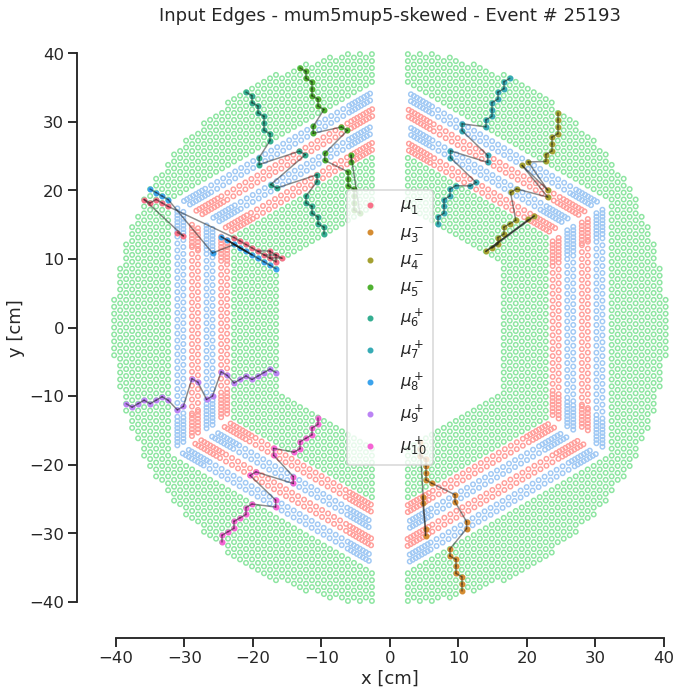

In [14]:
input_edges = feature_data.layerwise_true_edges    

print(len(input_edges[0]))
print(feature_data.scores[4].item())

fig, ax = plotSTT()

# feature data
x,y,_ = cylindrical_to_cartesian(r=feature_data.x[:, 0], phi=feature_data.x[:, 1], z=feature_data.x[:, 2])
    
# particle tracks
uniqueIds = np.unique(feature_data.pid)
numUniqueIds = len(uniqueIds)
particleColors = sns.color_palette("husl", numUniqueIds)

trackNum = 0
for pid in uniqueIds:
    idx = feature_data.pid == pid
    ax.scatter(x[idx], y[idx], label=f"${getParticleTexName(feature_data.pdgcode[idx][0].item())}_{{{pid:.0f}}}$", color=particleColors[trackNum], s=20)
    trackNum += 1
    
# input edges
for iedge in range(len(input_edges[0])):
	ptx1 = x[input_edges[0][iedge]]
	ptx2 = x[input_edges[1][iedge]]
	pty1 = y[input_edges[0][iedge]]
	pty2 = y[input_edges[1][iedge]]
	ax.plot([ptx1, ptx2], [pty1, pty2], color='k', alpha=0.5, lw=1.5)

ax.set_title(f'Input Edges - {project_name} - Event # {eventNum}')
ax.legend(loc='center')

fig.savefig(f"{image_dir}/input_edges_{eventNum}.pdf", dpi=300)
fig.savefig(f"{image_dir}/input_edges_{eventNum}.png", dpi=300)